# MACHINE LEARNING BINARY

This notebook test the machine learning model for binary prediction, if it is normal traffic or an attack

### INSTALLATION

In [72]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import unsloth
import xgboost as xgb
import lightgbm as lgb

from datasets import Dataset, load_dataset, load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from trl import SFTTrainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tqdm import tqdm

### Notebook

### DATA PREPARATION

In [38]:
# Read dataset
csv_path = "../data/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path,low_memory=False)
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.file_data,http.content_length,http.request.uri.query,http.request.method,http.referer,http.request.full_uri,http.request.version,http.response,http.tls_port,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.fin,tcp.connection.rst,tcp.connection.syn,tcp.connection.synack,tcp.dstport,tcp.flags,tcp.flags.ack,tcp.len,tcp.options,tcp.payload,tcp.seq,tcp.srcport,udp.port,udp.stream,udp.time_delta,dns.qry.name,dns.qry.name.len,dns.qry.qu,dns.qry.type,dns.retransmission,dns.retransmit_request,dns.retransmit_request_in,mqtt.conack.flags,mqtt.conflag.cleansess,mqtt.conflags,mqtt.hdrflags,mqtt.len,mqtt.msg_decoded_as,mqtt.msg,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.153346e+09,47892.0,0.0,0.0,0.0,1.0,64855.0,18.0,1.0,0.0,020405b40101040201030307,0,0.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.447945e+08,16077.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,14.0,0,100c00044d5154540402003c0000,1.0,64855.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,2.0,16.0,12.0,0.0,0,1.0,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,62675.0,0.0,0.0,0.0,0.0,64855.0,16.0,1.0,0.0,0,0,1.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.153346e+09,54469.0,0.0,0.0,0.0,0.0,64855.0,24.0,1.0,4.0,0,20020000,1.0,1883.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0x00000000,0.0,0.0,32.0,2.0,0.0,0,2.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.447945e+08,53812.0,0.0,0.0,0.0,0.0,1883.0,24.0,1.0,41.0,0,3027001854656d70657261747572655f616e645f48756d...,15.0,64855.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,48.0,39.0,0.0,32342e36382037362e34320d0a,3.0,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [39]:
print(df.columns)

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [40]:
# Save a backup of the dataframe
df_bp = df

### DATA PREPROCESSING

In [41]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [42]:
df.isna().sum()

frame.time                   0
ip.src_host                  0
ip.dst_host                  0
arp.dst.proto_ipv4           0
arp.opcode                   0
arp.hw.size                  0
arp.src.proto_ipv4           0
icmp.checksum                0
icmp.seq_le                  0
icmp.transmit_timestamp      0
icmp.unused                  0
http.file_data               0
http.content_length          0
http.request.uri.query       0
http.request.method          0
http.referer                 0
http.request.full_uri        0
http.request.version         0
http.response                0
http.tls_port                0
tcp.ack                      0
tcp.ack_raw                  0
tcp.checksum                 0
tcp.connection.fin           0
tcp.connection.rst           0
tcp.connection.syn           0
tcp.connection.synack        0
tcp.dstport                  0
tcp.flags                    0
tcp.flags.ack                0
tcp.len                      0
tcp.options                  0
tcp.payl

### Feature selection

We use a random forest classifier to select the best 7 features.

dns.qry.name.len     0.205840
mqtt.protoname       0.138802
mqtt.msg             0.109687
mqtt.topic           0.101408
mqtt.conack.flags    0.095618
tcp.options          0.081726
tcp.dstport          0.055727
dtype: float64


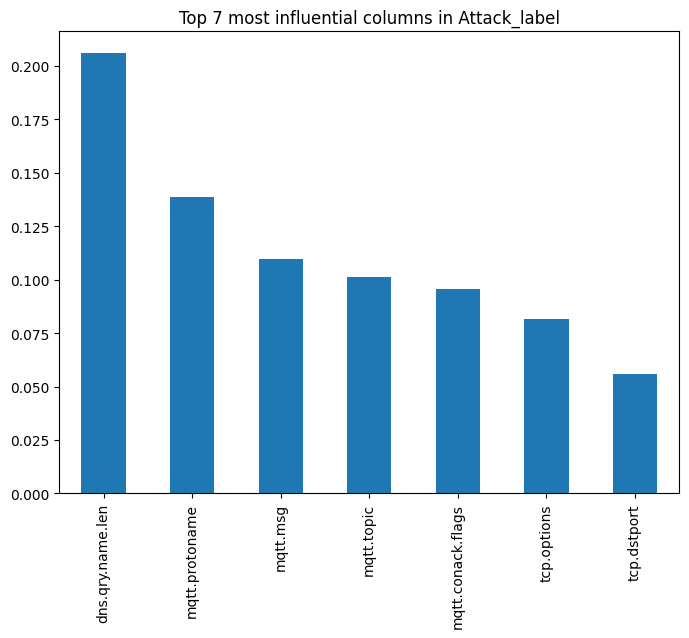

In [43]:
# Convert Attack_label to an integer (0 or 1)
df["Attack_label"] = df["Attack_label"].astype(int)

# Remove unnecessary columns
df = df.drop(["frame.time", "Attack_type"], axis=1, errors="ignore")

# Convert categorical variables into numerical values
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target variable
X = df.drop(columns=["Attack_label"])
y = df["Attack_label"]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 15 most influential features
print(feature_importance.head(7))

# Plot feature importance
plt.figure(figsize=(8,6))
feature_importance.head(7).plot(kind="bar")
plt.title("Top 7 most influential columns in Attack_label")
plt.show()

In [44]:
# Define the selected columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport"
]

# Filter the dataset to keep only these columns + target variable
df_selected = df_bp[selected_columns + ["Attack_label"]]

In [45]:
df_selected.head()

,dns.qry.name.len,mqtt.protoname,mqtt.msg,mqtt.topic,mqtt.conack.flags,tcp.options,tcp.dstport,Attack_label
0,0,0,0,0,0,020405b40101040201030307,64855.0,0
1,0,MQTT,0,0,0,0,1883.0,0
2,0,0,0,0,0,0,64855.0,0
3,0,0,0,0,0x00000000,0,64855.0,0
4,0,0,32342e36382037362e34320d0a,Temperature_and_Humidity,0,0,1883.0,0


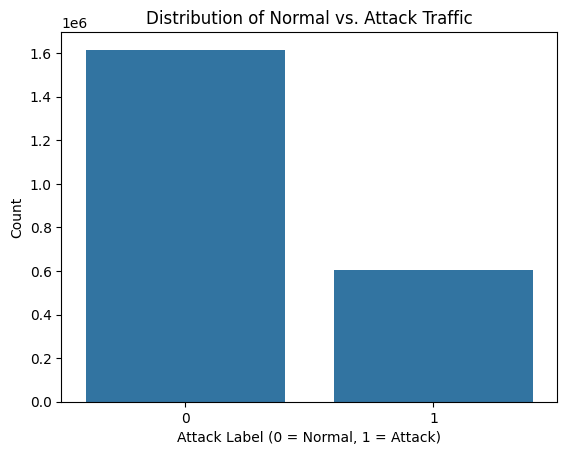

In [46]:
# Count occurrences of each class
sns.countplot(x=df_selected["Attack_label"])
plt.title("Distribution of Normal vs. Attack Traffic")
plt.xlabel("Attack Label (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

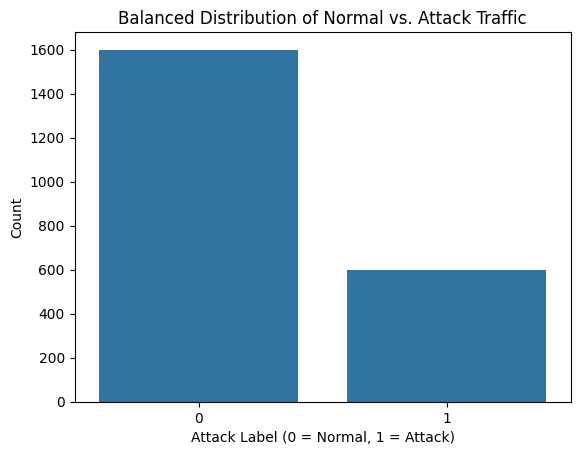

In [47]:
# 1600 samples of normal traffic and 600 samples of attack traffic
df_attack = df_selected[df_selected["Attack_label"] == 1].sample(n=600, random_state=42)
df_normal = df_selected[df_selected["Attack_label"] == 0].sample(n=1600, random_state=42)

# Concat both
df_balanced = pd.concat([df_attack, df_normal]).sample(frac=1, random_state=42)

sns.countplot(x=df_balanced["Attack_label"])
plt.title("Balanced Distribution of Normal vs. Attack Traffic")
plt.xlabel("Attack Label (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

### ONE-HOT ENCODING

In [55]:
# Columns to One-Hot Encode
categorical_columns = ["dns.qry.name.len","mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags", "tcp.options"]

# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_balanced, columns=categorical_columns, drop_first=True)

print(df_encoded.head())


         tcp.dstport  Attack_label  dns.qry.name.len_0.0  \
848122       57973.0             0                 False   
571599       60944.0             0                 False   
1193375       1883.0             0                 False   
516958        1883.0             0                 False   
1536165       1883.0             0                 False   

         dns.qry.name.len_1.0  dns.qry.name.len_2.debian.pool.ntp.org  \
848122                  False                                   False   
571599                  False                                   False   
1193375                 False                                   False   
516958                  False                                   False   
1536165                 False                                   False   

         mqtt.protoname_0.0  mqtt.protoname_MQTT  mqtt.msg_0.0  \
848122                False                False         False   
571599                False                False         False   
11

In [56]:
y = df_encoded["Attack_label"] 
X = df_encoded.drop(columns=["Attack_label"]) 

### TRAIN MODELS

Split data

In [57]:
# Split Data into Train and Test Sets (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  
)

#### RANDOM FOREST

In [59]:
# Initialize and Train RandomForest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make Predictions on Test Data
y_pred_RF = model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_RF)
report = classification_report(y_test, y_pred_RF) 
f1 = f1_score(y_test, y_pred_RF, average="weighted")

# Print Results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(report)

✅ Accuracy: 1.0000
✅ F1-Score: 1.0000

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       180

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660



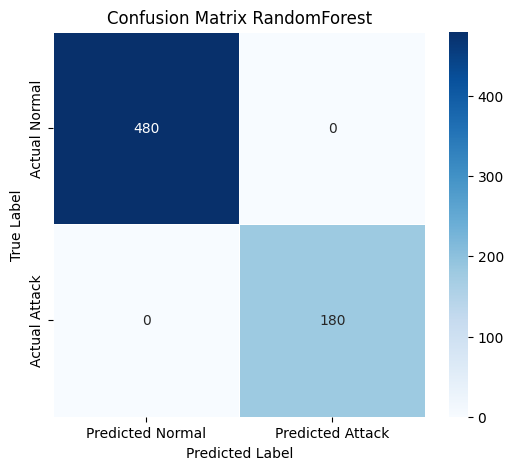

In [60]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Normal", "Actual Attack"], columns=["Predicted Normal", "Predicted Attack"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix RandomForest")
plt.show()


#### XGBOOST

In [61]:
# Initialize and Train XGBoost Model
model = xgb.XGBClassifier(
    n_estimators=100,    
    max_depth=6,       
    learning_rate=0.1, 
    subsample=0.8,       
    colsample_bytree=0.8, 
    random_state=42,
    use_label_encoder=False,  
    eval_metric="logloss" 
)

# Train model
model.fit(X_train, y_train)

# Make Predictions on Test Data
y_pred_xg = model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_xg)
f1 = f1_score(y_test, y_pred_xg, average="weighted")
report = classification_report(y_test, y_pred_xg)

# Print Results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(report)

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9985
✅ F1-Score: 0.9985

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      0.99      1.00       180

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660



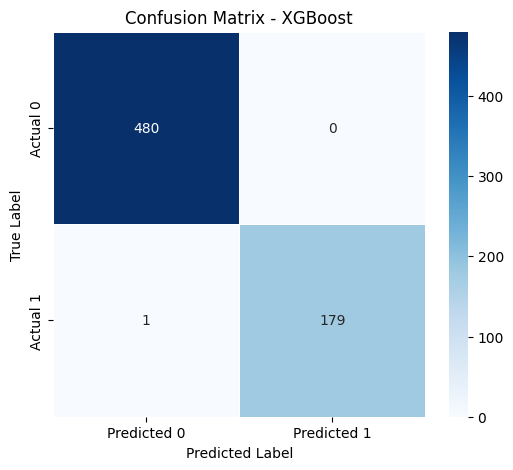

In [62]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xg)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

#### LIGHTBM

In [63]:
# Initialize and Train LightGBM Model for Binary Classification
model = lgb.LGBMClassifier(
    n_estimators=300,  
    max_depth=-1,  
    learning_rate=0.05,  
    num_leaves=50, 
    min_data_in_leaf=10,  
    subsample=0.7,  
    colsample_bytree=0.7,  
    class_weight="balanced",  
    random_state=42
)

# Train the model
model.fit(X_train, y_train) 

# Make Predictions on Test Data
y_pred_lgbm = model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm, average="weighted")
report = classification_report(y_test, y_pred_lgbm)

# Print Results
print(f"✅ Accuracy (LightGBM): {accuracy:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\n📊 Classification Report (LightGBM):")
print(report)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 420, number of negative: 1120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

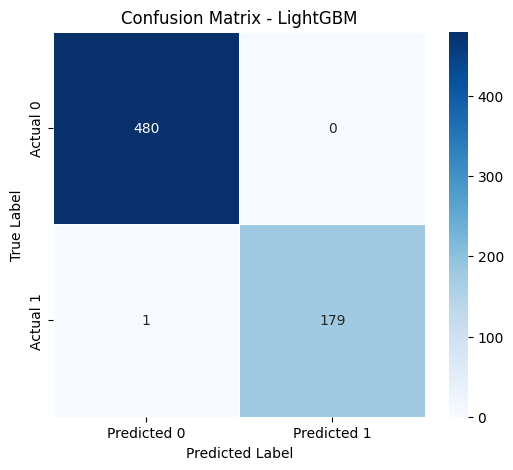

In [64]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()

#### MLP

In [70]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define MLP Model for Binary Classification
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(64, 1)  # Output layer changed for binary classification

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.output_layer(x))  # Sigmoid for binary classification

# Convert pandas Series to NumPy arrays before creating PyTorch tensors
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)  # Convert to float and reshape
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)


# Configure model
input_dim = X_train.shape[1]
model = MLP(input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
batch_size = 64
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Make Predictions on Test Data
with torch.no_grad():
    y_pred_mlp = (model(X_test_tensor) >= 0.5).int().numpy().flatten()  # Convert probabilities to binary

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp, average="weighted")
report = classification_report(y_test, y_pred_mlp, zero_division=0)

# Print Results
print(f"✅ Accuracy (MLP): {accuracy:.4f}")
print(f"✅ F1-Score (MLP): {f1:.4f}")
print("\n📊 Classification Report (MLP):")
print(report)

Epoch 10/100, Loss: 0.0078
Epoch 20/100, Loss: 0.0022
Epoch 30/100, Loss: 0.0008
Epoch 40/100, Loss: 0.0008
Epoch 50/100, Loss: 0.0004
Epoch 60/100, Loss: 0.0002
Epoch 70/100, Loss: 0.0003
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0002
✅ Accuracy (MLP): 1.0000
✅ F1-Score (MLP): 1.0000

📊 Classification Report (MLP):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       1.00      1.00      1.00       180

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660



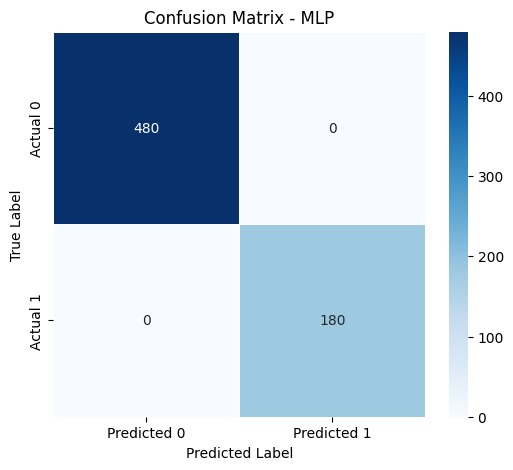

In [71]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mlp)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MLP")
plt.show()

### RESULTS COMPARISON

In [73]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred, average="weighted"),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted")
    }

# Calculate metrics
metrics_mlp = compute_metrics(y_test, y_pred_mlp)
metrics_xgb = compute_metrics(y_test, y_pred_xg)
metrics_lgbm = compute_metrics(y_test, y_pred_lgbm)
metrics_rf = compute_metrics(y_test, y_pred_RF)

# Create dataframe
metrics_comparison_df = pd.DataFrame({
    "MLP": metrics_mlp,
    "XGBoost": metrics_xgb,
    "LightGBM": metrics_lgbm,
    "RandomForest": metrics_rf,
}).T  

# Show table
print(metrics_comparison_df)

              Accuracy  F1 Score  Precision    Recall
MLP           1.000000  1.000000   1.000000  1.000000
XGBoost       0.998485  0.998484   0.998488  0.998485
LightGBM      0.998485  0.998484   0.998488  0.998485
RandomForest  1.000000  1.000000   1.000000  1.000000
